In [1]:
from cobra.flux_analysis import gapfill
from cobra.flux_analysis.gapfilling import GapFiller
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Model, Reaction, Metabolite
import pandas
import sys
import re

In [2]:
def repair_mass_balance(model, delete_unbalanced=True, verbose=False):
    mod = model.copy()
    Cwrong = 0
    Ccorrected = 0
    if "cpd00067_c0" not in mod.metabolites:
        h = Metabolite(id="cpd00067_c0", name="H+", formula="H", charge=1)
        mod.add_metabolites(h)
    
    rea_rm = []
    for r in mod.reactions:
        if r in mod.exchanges or r.id=="bio1":
            continue
        
        mbal = r.check_mass_balance()        
        if mbal != {}:         
            Cwrong += 1
            if "charge" in mbal:
                miss = mbal["charge"]
            else:
                if verbose:
                    print "could not be fixed"
                    print "\t",r.id, r.name, r.reaction
                    print "\t",mbal
                if delete_unbalanced:
                    rea_rm.append(r)
                    #mod.remove_reactions(r)
                continue
            if miss != round(miss): # check if integer
                print "error in", r.id, "mass imbalance:", mbal
                if delete_unbalanced:
                    rea_rm.append(r)
                    #mod.remove_reactions(r)
                continue
            h = mod.metabolites.get_by_id("cpd00067_c0")
            if miss < 0:
                r.add_metabolites({h: -miss})
            if miss > 0:
                r.subtract_metabolites({h: miss})
            if r.check_mass_balance() != {}:
                if verbose:
                    print r.id, r.name, r.reaction
                    print "old:",mbal, "\tnew:",r.check_mass_balance()
                if delete_unbalanced:
                    rea_rm.append(r)
                    #mod.remove_reactions(r)
            else:
                if verbose:
                    print r.id, "fixed"
                Ccorrected += 1
    mod.remove_reactions(rea_rm)
    mod.repair()
    print "Unbalanced reactions:", Cwrong, "\tCould be corrected:", Ccorrected, "\tRemoved reactions:", len(model.reactions)-len(mod.reactions)
    return(mod)

In [3]:
seedrDB = pandas.read_csv("/home/jo/uni/gapseq/dat/seed_reactions.tsv", sep="\t")
seedmDB = pandas.read_csv("/home/jo/uni/gapseq/dat/seed_metabolites.tsv", sep="\t")
mod = repair_mass_balance(read_sbml_model("/home/jo/uni/gapseq/dat/myb71.xml"), verbose=False)
with open("/home/jo/uni/gapseq/newReactions.lst") as f:
#with open("/home/jo/uni/gapseq/newReactions5.lst") as f:
    lines = f.read()
newR = lines.split(" ")

/usr/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718 DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.


Unbalanced reactions: 49 	Could be corrected: 49 	Removed reactions: 0


In [14]:
#
# Create reference model with reactions pool
#

refdb  = seedrDB.loc[seedrDB['id'].isin(newR)]
refmod = Model("reaction_database")
Rmod   = [re.sub("_.*$", "", r.id) for r in mod.reactions]
print "Consider", len(refdb.index), "reactions"
Cold = 0
Calready = 0
for i,row in refdb.iterrows():
    #print row["code"]
    rid = row["id"]
    if row["is_obsolete"] == 1: # do not add old reactions
        Cold += 1
        continue
    elif rid in Rmod:
        Calready += 1
        continue
    r = Reaction(rid)
    refmod.add_reaction(r)
    rstr = row["equation"]
    #rstr = row["code"]
    rstr = rstr.replace("[0]", "_c0").replace("[1]", "_e0").replace("[3]", "_p0")
    r.build_reaction_from_string(rstr, verbose=False)
    #r.reaction = rstr
for m in refmod.metabolites:
    mid =re.sub("_.*$","", m.id)
    hit = seedmDB.loc[seedmDB["id"]==mid]
    m.name = hit["name"].values[0]
    m.formula = hit["formula"].values[0]
    m.charge = hit["charge"].values[0]

print Calready, "reactions already in the model"
print Cold, "removed deprecated reactions"
refmod = repair_mass_balance(refmod)
print len(refmod.reactions), "remaining reaction in reference database:", 

# equation: Unbalanced reactions: 425 	Could be corrected: 4 	Removed reactions: 421
# code: Unbalanced reactions: 1369 	Could be corrected: 949 	Removed reactions: 420

Consider 577 reactions
113 reactions already in the model
31 removed deprecated reactions
Unbalanced reactions: 117 	Could be corrected: 0 	Removed reactions: 117
Remaining reaction in reference database: 316


In [13]:
Rmod   = [re.sub("_.*$", "", r.id) for r in mod.reactions]
Rmod[1:10]
#refmod.reactions[1:10]

['rxn00351',
 'rxn07431',
 'rxn00836',
 'rxn00390',
 'rxn08180',
 'rxn00423',
 'rxn00364',
 'rxn05561',
 'rxn03408']

In [15]:
Cerror = 0
test = refmod
for r in test.reactions:
    if r in test.exchanges or r.id=="bio1":
            continue
    if r.check_mass_balance() != {}:
        Cerror += 1
        r.remove_from_model()
print Cerror

0


In [16]:
def set_medium(model, medium):
    mod = model.copy()
    for ex in mod.exchanges:
        ex.lower_bound=0

    for m in medium: # set medium
        ex = "EX_"+m+"_e0"
        #ex = m
        if ex in mod.reactions:
            mod.reactions.get_by_id(ex).lower_bound=-1000
        else:
            print "compound not found in model:", m
    return(mod)

In [17]:
#
# Iterate by biomass components and try to produce components step-wise by minimal medium only
# => if biomass component could not be produced => gapfilling
#

#richmed = ["EX_cpd00001_e0", "EX_cpd00007_e0","EX_cpd00009_e0", "EX_cpd00018_e0", "EX_cpd00023_e0", "EX_cpd00027_e0", "EX_cpd00028_e0", "EX_cpd00030_e0", "EX_cpd00033_e0", "EX_cpd00034_e0", "EX_cpd00035_e0", "EX_cpd00039_e0", "EX_cpd00041_e0", "EX_cpd00046_e0", "EX_cpd00048_e0", "EX_cpd00051_e0", "EX_cpd00054_e0", "EX_cpd00058_e0", "EX_cpd00060_e0", "EX_cpd00063_e0", "EX_cpd00065_e0", "EX_cpd00066_e0", "EX_cpd00067_e0", "EX_cpd00069_e0", "EX_cpd00084_e0", "EX_cpd00091_e0", "EX_cpd00092_e0", "EX_cpd00099_e0", "EX_cpd00107_e0", "EX_cpd00119_e0", "EX_cpd00126_e0", "EX_cpd00129_e0", "EX_cpd00149_e0", "EX_cpd00156_e0", "EX_cpd00161_e0", "EX_cpd00182_e0", "EX_cpd00184_e0", "EX_cpd00205_e0", "EX_cpd00215_e0", "EX_cpd00218_e0", "EX_cpd00219_e0", "EX_cpd00220_e0", "EX_cpd00226_e0", "EX_cpd00239_e0", "EX_cpd00246_e0", "EX_cpd00249_e0", "EX_cpd00254_e0", "EX_cpd00311_e0", "EX_cpd00322_e0", "EX_cpd00381_e0", "EX_cpd00383_e0", "EX_cpd00393_e0", "EX_cpd00438_e0", "EX_cpd00531_e0", "EX_cpd00541_e0", "EX_cpd00644_e0", "EX_cpd00654_e0", "EX_cpd00793_e0", "EX_cpd00971_e0", "EX_cpd01012_e0", "EX_cpd01048_e0", "EX_cpd03424_e0", "EX_cpd10515_e0", "EX_cpd10516_e0", "EX_cpd11595_e0"]
minmed = ["cpd00027", "cpd00007", "cpd00001", # glc, o2, h2o
          "cpd00013", # nh3
          # minerals
          "cpd00009", "cpd00030", "cpd00034", "cpd00058", "cpd00063", "cpd00067", "cpd00099", "cpd00205", "cpd00254", "cpd10515", "cpd00971", "cpd01012", "cpd10516", "cpd11574"]

modmin = set_medium(mod, minmed)
modnew = mod.copy()


    
Call=0; Cwork=0; Cfix=0
fixLater = []
fail = []
relMet = ["cpd00288_c0"]
allMet = mod.reactions.bio1.reactants + [modmin.metabolites.get_by_id(m) for m in relMet]
bioaa = [m for m in mod.metabolites if m.name.startswith("L_") and m in mod.reactions.bio1.metabolites]
for m in bioaa:
#for m in allMet:
    Call += 1
    modtmp = modmin.copy()
    modtmp.objective = modtmp.add_boundary(m, type='demand')
    obj = modtmp.slim_optimize()
    if obj > 0:
        #print "\t => could be produced:"
        Cwork += 1
    else:
        # gapfilling
        print obj, m.id, m.name
        try:
            gapsol = gapfill(modtmp, refmod) # integer_threshold=1e-06
        except RuntimeError:
            print "\t => Runtime error: lowering the integer_threshold?"
            fixLater.append(m)
            continue
        except:
            print "\t => failed:", sys.exc_info()[0]
            fail.append(m)
            continue
        if len(gapsol[0]) > 0:
            Cfix += 1
            print "\t => could be fixed:", ",".join([r.id for r in gapsol[0]])
            modnew.add_reactions([r for r in gapsol[0] if r not in modnew.reactions])
print "\nTotal compounds:", Call, "\t can be produced:", Cwork, "\t could be fixed", Cfix, "\t altogether:", round(100*float(Cwork+Cfix)/Call,1), "%", " (before:",round(100*float(Cwork)/Call,1),"% )"

compound not found in model: cpd10515
compound not found in model: cpd11574
0.0 cpd00060_c0 L_Methionine_c0
	 => failed: <class 'cobra.exceptions.Infeasible'>
0.0 cpd00084_c0 L_Cysteine_c0
	 => failed: <class 'cobra.exceptions.Infeasible'>
0.0 cpd00066_c0 L_Phenylalanine_c0
	 => could be fixed: rxn01256
0.0 cpd00107_c0 L_Leucine_c0
	 => could be fixed: rxn02186
0.0 cpd00069_c0 L_Tyrosine_c0
	 => could be fixed: rxn01256
0.0 cpd00322_c0 L_Isoleucine_c0
	 => could be fixed: rxn33937
0.0 cpd00039_c0 L_Lysine_c0
	 => failed: <class 'cobra.exceptions.Infeasible'>
0.0 cpd00156_c0 L_Valine_c0
	 => could be fixed: rxn02186

Total compounds: 19 	 can be produced: 11 	 could be fixed 5 	 altogether: 84.2 %  (before: 57.9 % )


In [ ]:
# Total compounds: 77 	 can be produced: 36 	 could be fixed 11 	 altogether: 61.0 %  (before: 46.8 % )

# Total compounds: 76 	 can be produced: 36 	 could be fixed 29 	 altogether: 85.5 %  (before: 47.4 % )
# Total compounds: 76 	 can be produced: 36 	 could be fixed 18 	 altogether: 71.1 %  (before: 47.4 % )

In [43]:
for m in fixLater:
    modtmp = modmin.copy()
    modtmp.objective = modtmp.add_boundary(m, type='demand')
    try:
        #gapsol = gapfill(modtmp, refmod) # integer_threshold=1e-06
        gapsol  = GapFiller(modtmp, refmod, integer_threshold=1e-16).fill()
    except RuntimeError:
            print m.id, m.name, "... no solution found ... still integer_threshold?"

Still integer_threshold?
Still integer_threshold?
Still integer_threshold?
Still integer_threshold?
Still integer_threshold?


In [18]:
#modnew = read_sbml_model("/home/jo/uni/gapseq/myb71_gapfilled.xml")
modnew.summary()
write_sbml_model(modnew, filename="/home/jo/uni/gapseq/myb71_gapfilled.xml")

IN FLUXES             OUT FLUXES            OBJECTIVES
--------------------  --------------------  ------------
cpd00027_e0    1e+03  cpd00001_e0    1e+03  bio1  235
cpd00073_e0    1e+03  cpd00011_e0    1e+03
cpd00226_e0    1e+03  cpd00013_e0    1e+03
cpd00276_e0    1e+03  cpd00035_e0    1e+03
cpd00307_e0    1e+03  cpd00067_e0    1e+03
cpd15560_e0  875      cpd00588_e0    1e+03
cpd00080_e0  857      cpd00122_e0  976
cpd00794_e0  565      cpd00092_e0  951
cpd00054_e0  429      cpd00309_e0  928
cpd00138_e0  362      cpd15561_e0  875
cpd00129_e0  360      cpd00036_e0  815
cpd00159_e0  335      cpd00009_e0  667
cpd17041_c0  235      cpd00033_e0  441
cpd17042_c0  235      cpd11416_c0  235
cpd17043_c0  235      cpd00117_e0  167
cpd00039_e0   72.9    cpd00007_e0   67.2
cpd15605_e0   36.3
cpd11590_e0   30.8
cpd15606_e0   29.1
cpd01080_e0   20
cpd00797_e0   20
cpd11584_e0   18.6
cpd01188_e0   11.1
cpd00106_e0   10.1
cpd00268_e0   10
cpd10516_e0    2.91
cpd11606_e0    2.18
cpd00220_e0    1.45
cp

In [34]:
modtmp = set_medium(modnew, minmed) # modnew?
m = modtmp.metabolites.get_by_id("cpd00309_c0")
modtmp.objective = modtmp.add_boundary(m, type='demand')
print modtmp.slim_optimize()
print gapfill(modtmp, refmod)

compound not found in model: cpd10515
compound not found in model: cpd11574
-1.29811380269e-12


Infeasible: gapfilling optimization failed

In [32]:
minmed

['cpd00027',
 'cpd00007',
 'cpd00001',
 'cpd00013',
 'cpd00009',
 'cpd00030',
 'cpd00034',
 'cpd00058',
 'cpd00063',
 'cpd00067',
 'cpd00099',
 'cpd00205',
 'cpd00254',
 'cpd10515',
 'cpd00971',
 'cpd01012',
 'cpd10516',
 'cpd11574']

In [23]:
m = mod.metabolites.get_by_id("cpd02229_c0")
for r in m.reactions:
    if r.id=="bio1": continue
    print r.build_reaction_string(use_metabolite_names=False)
    print r.build_reaction_string(use_metabolite_names=True) + "\n"

cpd03495_c0 + cpd15666_c0 <=> cpd02229_c0 + cpd15665_c0
Undecaprenyl_diphospho_N_acetylmuramoyl__N_acetylglucosamine_L_ala_D_glu_meso_2_6_diaminopimeloyl_D_ala_D_ala_c0 + Peptidoglycan_polymer_n_1_subunits_c0 <=> Bactoprenyl_diphosphate_c0 + Peptidoglycan_polymer_n_subunits_c0

cpd00001_c0 + cpd02229_c0 --> cpd00009_c0 + 2.0 cpd00067_c0 + cpd00286_c0
H2O_c0 + Bactoprenyl_diphosphate_c0 --> Phosphate_c0 + 2.0 H_plus__c0 + Undecaprenylphosphate_c0

8.0 cpd00113_c0 + cpd00350_c0 <=> 8.0 cpd00012_c0 + 8.0 cpd00067_c0 + cpd02229_c0
8.0 Isopentenyldiphosphate_c0 + Farnesyldiphosphate_c0 <=> 8.0 PPi_c0 + 8.0 H_plus__c0 + Bactoprenyl_diphosphate_c0



In [40]:
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba
import pandas

In [59]:
med = ["cpd11606", "cpd00305","cpd00048","cpd00058", "cpd00034", "cpd10516", "cpd00254", "cpd00205", "cpd00030", "cpd00149", "cpd00099", "cpd00063"]
minmed = ["cpd00027", "cpd00007", "cpd00001", # glc, o2, h2o
          "cpd00013", # nh3
          # minerals
          "cpd00009", "cpd00030", "cpd00034", "cpd00058", "cpd00063", "cpd00067", "cpd00099", "cpd00205", "cpd00254", "cpd10515", "cpd00971", "cpd01012", "cpd10516", "cpd11574"]

modtmp = set_medium(modnew, minmed)
nominal = modtmp.optimize()
loopless = loopless_solution(modnew)
print nominal.objective_value, loopless.fluxes["bio1"]

compound not found in model: cpd10515
compound not found in model: cpd11574
-1.56153224243e-13 271.282955535


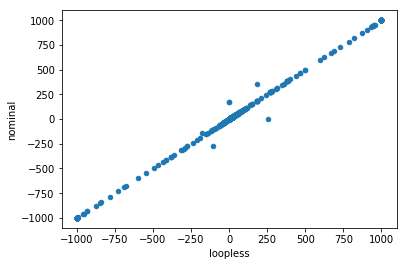

In [48]:
df = pandas.DataFrame(dict(loopless=loopless.fluxes, nominal=nominal.fluxes))
df.plot.scatter(x='loopless', y='nominal')